In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import math
import IPython.display as ipd

In [3]:
audio_path = r'dataset/raw/2473663/2243804495.mp3'

In [4]:
window_size = 2048
step_size = 512
sample_rate = 44100
filter_banks = 128

In [5]:
#split a time series into multiple frames given a window size and step size
def get_even_time_series_frames(time_series : np.array, window_size : int, step_size : int):
    #calculate number of frames (has to be an even number?)
    frame_num = (len(time_series) - window_size)/step_size + 1
    series = time_series #copy series
    if frame_num % 2 != 0:  #ensure that number of frames is a even number
        frame_num = math.ceil(frame_num / 2.0) * 2 #round number of frames to even number
        padding_len = (frame_num - 1) * step_size + window_size - len(time_series)  #calculate padding length 
        series = np.pad(series, (0, padding_len), 'constant') #pad end of series with 0s
    frame_num = int(frame_num)
    #create and return frames from rime series 
    return np.array([ series[step*step_size:step*step_size+window_size] for step in range(frame_num)])

In [6]:
#convert frequency to mel scale
def frequency_to_mel(freq):
    return 2595 * np.log10(1 + freq / 700)

#convert mel to frequency
def mel_to_frequency(mel):
    return 700 * (10 **(mel / 2595) - 1)

In [7]:
def create_filter_bank(sample_rate, n_fft, n_filters, freq_min = 0, freq_max = 22050):
    #convert min and max frequency to mel scale
    min_mel = frequency_to_mel(freq_min)
    max_mel = frequency_to_mel(freq_max)
    #create linearly spaced points between the min and max mel
    mel_points = np.linspace(min_mel, max_mel, n_filters + 2)
    #print(mel_points)    
    #convert mel points back to hz
    freq_points = mel_to_frequency(mel_points)
    #print(freq_points)
    #round frequency points to nearest fourier transform bin (n_fft)
    freq_bins = np.floor((n_fft + 1) * freq_points / sample_rate).astype(int)
    print(freq_bins)
    fbank = np.zeros((n_filters, int(np.floor(n_fft / 2 + 1))))
    for m in range(1, n_filters + 1):
        filter_bank_start = freq_bins[m - 1]
        filter_bank_max   = freq_bins[m]
        filter_bank_end   = freq_bins[m + 1]

        for k in range(filter_bank_start, filter_bank_max):
            #print(k)
            fbank[m - 1, k] = (k - freq_bins[m - 1]) / (freq_bins[m] - freq_bins[m - 1])
        for k in range(filter_bank_max, filter_bank_end):
            fbank[m - 1, k] = (freq_bins[m + 1] - k) / (freq_bins[m + 1] - freq_bins[m])

    return fbank

In [8]:
def apply_filter_banks(power_spectrum, sample_rate, n_fft, n_filters, freq_min = 0, freq_max = 22050):
    #convert min and max frequency to mel scale
    min_mel = frequency_to_mel(freq_min)
    max_mel = frequency_to_mel(freq_max)
    #create linearly spaced points between the min and max mel
    mel_points = np.linspace(min_mel, max_mel, n_filters + 2)
    #convert mel points back to hz
    freq_points = mel_to_frequency(mel_points)
    #round frequency points to nearest fourier transform bin (n_fft)
    freq_bins = np.floor((n_fft + 1) * freq_points / sample_rate)

    fbank = np.zeros((n_filters, int(np.floor(n_fft / 2 + 1))))
    for m in range(1, n_filters + 1):
        filter_bank_start = freq_bins[m - 1]
        filter_bank_max   = freq_bins[m]
        filter_bank_end   = freq_bins[m + 1]

        for k in range(filter_bank_start, filter_bank_max):
            #print(k)
            fbank[m - 1, k] = (k - freq_bins[m - 1]) / (freq_bins[m] - freq_bins[m - 1])
        for k in range(filter_bank_max, filter_bank_end):
            fbank[m - 1, k] = (freq_bins[m + 1] - k) / (freq_bins[m + 1] - freq_bins[m])

    filter_banks = np.dot(power_spectrum, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    #

    return filter_banks

In [9]:
def draw_spectogram(spectogram_matrix):
    f = plt.figure(figsize=(10,5), dpi= 80)
    ax = f.add_subplot()
    ax.set_title('Mel-frequency spectrogram') #set title 
    mfcc = ax.matshow(spectogram_matrix, aspect="auto", cmap=plt.get_cmap('magma')) #draw matrix with colormap 'magma'
    ax.xaxis.set_ticks_position('bottom') #set x ticks to bottom of graph 
    ax.set_xlabel('Time (sec)')
    ax.invert_yaxis() #have y axis start from the bottom
    ax.set_ylabel('Hz')
    plt.tight_layout()
    plt.colorbar(mfcc, format='%+2.0f dB');
    plt.show()

In [10]:
#sample audio at 44.1 khz and get the time series as a numpy array
time_series, sample_rate = librosa.load(audio_path, sr = sample_rate)
#trim empty start and end padding from time series
time_series, _ = librosa.effects.trim(time_series)

In [11]:
time_series_frames = get_even_time_series_frames(time_series, 2048, 512)

In [12]:
lib_frames = librosa.util.frame(time_series, 2048, 512)
lib_frames = lib_frames.T

In [13]:
print((lib_frames == time_series_frames).all())
print(np.array_equal(lib_frames, time_series_frames))
print('librosa: {} own: {}'.format(lib_frames.shape, time_series_frames.shape))

True
True
librosa: (1158, 2048) own: (1158, 2048)


In [14]:
windowed_frames = time_series_frames * np.hanning(window_size)

In [15]:
lib_windowed_frames = lib_frames * np.hanning(window_size)

In [16]:
mag_frames = np.abs(np.fft.rfft(windowed_frames, 2048))
pow_frames = ((1.0 / 2048) * ((mag_frames) ** 2))

In [17]:
lib_mag_frames = np.abs(np.fft.rfft(lib_windowed_frames, 2048))
lib_pow_frames = ((1.0 / 2048) * ((lib_mag_frames) ** 2))

In [41]:
mel = librosa.filters.mel(sr=16000, n_fft=512, n_mels=10, fmin = 300, fmax=8000)
mel[0][:8 * 5]


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00020498, 0.00071744, 0.00122989, 0.00174235, 0.0022548 ,
       0.00276726, 0.00327971, 0.00379217, 0.00379441, 0.00328195,
       0.0027695 , 0.00225704, 0.00174459, 0.00123213, 0.00071968,
       0.00020722, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

In [19]:
#librosa.filters.mel(sr=16000, n_fft=400, n_mels=10, fmin = 300,  fmax=8000).shape


In [39]:
own_mel = create_filter_bank(16000, n_fft=512, n_filters=10, freq_min = 300, freq_max=8000)

#print(np.fft.rfftfreq(2048, d=1/16000))
own_mel[0][:8*5]

[ 300.          517.33705295  781.90950049 1103.98334406 1496.05576763
 1973.34005629 2554.35590566 3261.64802744 4122.66093456 5170.80384945
 6446.74705655 8000.        ]
[  9  16  25  35  47  63  81 104 132 165 206 256]


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.14285714, 0.28571429, 0.42857143, 0.57142857, 0.71428571,
       0.85714286, 1.        , 0.88888889, 0.77777778, 0.66666667,
       0.55555556, 0.44444444, 0.33333333, 0.22222222, 0.11111111,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [21]:
mel_scale_frames = mel.dot(pow_frames.T)

In [22]:
lib_mel_scale_frames = mel.dot(lib_pow_frames.T)

In [23]:
np.array_equal(mel_scale_frames, lib_mel_scale_frames)

True

In [24]:
db_scale_frames = librosa.power_to_db(mel_scale_frames, ref=np.max)

In [25]:
lib_db_scale_frames = librosa.power_to_db(lib_mel_scale_frames, ref=np.max)

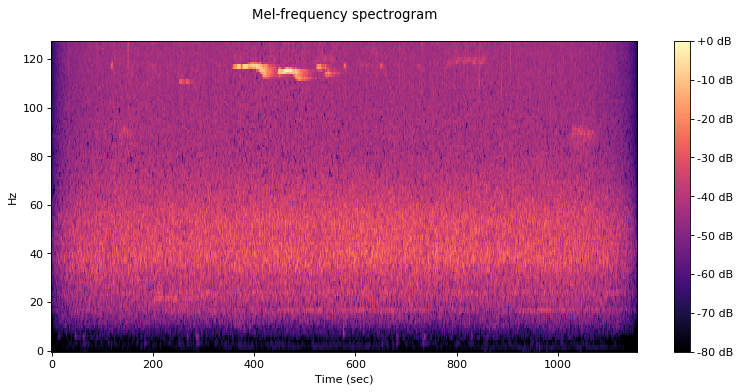

In [26]:
draw_spectogram(db_scale_frames)

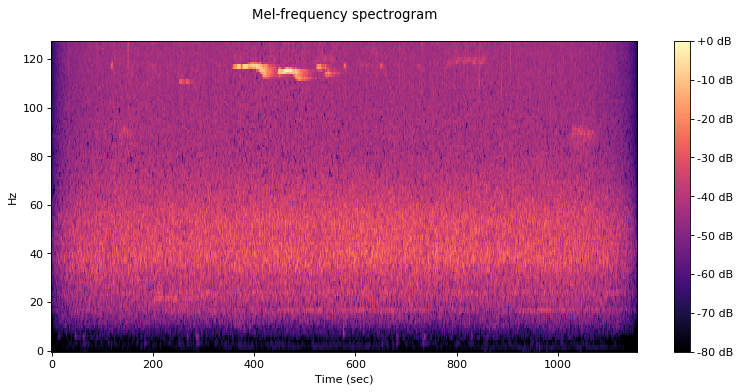

In [27]:
draw_spectogram(lib_db_scale_frames)